In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score,confusion_matrix

import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import random
import pathlib
from tensorflow.keras import layers
import numpy as np
import seaborn as sns

In [2]:
malwere_df = pd.read_csv('./ML_Academy/Data/CSV_malware.csv')
bengin_df = pd.read_csv('./ML_Academy/Data/CSV_benign.csv')

C:\Users\macie\AppData\Local\Temp/ipykernel_916/2312792024.py:2: DtypeWarning: Columns (9,10,12,13,17,18,20,21,24,25,27,28,36) have mixed types. Specify dtype option on import or set low_memory=False.
  bengin_df = pd.read_csv('./ML_Academy/Data/CSV_benign.csv')


In [3]:
len(malwere_df),len(bengin_df)

(4999, 494135)

Widzimy że mamy doczynienia z bardzo mocno niezbalansowanym zbiorem, zatem w wyborze featerów musimy uwzględniać takie które są najbardziej reprezentowane w mniejszym zbiorze

Wiek Domeny 

<AxesSubplot:>

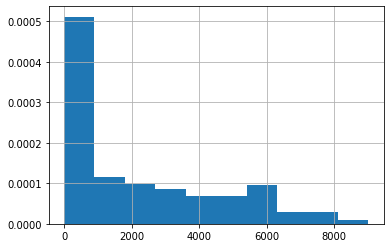

In [5]:
dominion_days = []
for data in malwere_df.Domain_Age:
    if type(data) == str:
        if ' days' in data:
            dominion_days.append(int(data.split(' days')[0]))
        else:
            dominion_days.append(0)
    else:
        dominion_days.append(0)
pd.Series(dominion_days).hist(density=1)

<AxesSubplot:>

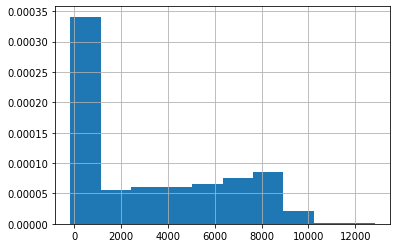

In [6]:
dominion_days = []
for data in bengin_df.Domain_Age:
    if type(data) == str:
        if ' days' in data:
            dominion_days.append(int(data.split(' days')[0]))
        else:
            dominion_days.append(0)
    else:
        dominion_days.append(0)
pd.Series(dominion_days).hist(density=True)

Widzimy  że zmienna daje nam informacje ponieważ wykresy się różnią

In [4]:
em_num = []
eml_domains = []
for i,data in enumerate(malwere_df.Emails):
    if type(data) == str:
        if '[' in data and ']' in data:
            res = data.strip('][').split(', ')
            eml_domains = eml_domains + ([x.split('@')[1].replace("'",'') for x in res if '@' in x] )
            em_num.append(len(res))
        else:
            if '@' in data:
                eml_domains.append(data.split('@')[1])
            else:
                eml_domains.append(None)
            em_num.append(1)
    else:
        eml_domains.append(None)
        em_num.append(0)

pd.Series(eml_domains).value_counts(normalize=True)

godaddy.com                    0.207376
web.com                        0.062072
NameBright.com                 0.056429
domainsbyproxy.com             0.048569
hugedomains.com                0.038694
                                 ...   
domainprivacyservice.com.au    0.000202
l.o-w-o.info                   0.000202
g.o-w-o.info                   0.000202
beaglebeat.com                 0.000202
300.cn                         0.000202
Name: proportion, Length: 403, dtype: float64

In [42]:
em_len = []
eml_domains = []
for i,data in enumerate(bengin_df.Emails):
    if type(data) == str:
        if '[' in data and ']' in data:
            res = data.strip('][').split(', ')
            eml_domains = eml_domains + [x.split('@')[1].replace("'",'') for x in res if '@' in x] 
            em_len.append(len(res))
        else:
            if '@' in data:
                eml_domains.append(data.split('@')[1])
            em_len.append(1)
    else:
        em_len.append(0)
    # if i > 20000:
    #     break

pd.Series(em_len).value_counts(normalize=True)
pd.Series(eml_domains).value_counts(normalize=True)

godaddy.com              0.097463
web.com                  0.095616
cscglobal.com            0.034174
namecheap.com            0.029031
markmonitor.com          0.023141
                           ...   
mail.videoland.com.tw    0.000002
kyosu.net                0.000002
leixun.net               0.000002
dongnhan.com             0.000002
erdemoto.com             0.000002
Name: proportion, Length: 16380, dtype: float64

In [41]:
em_len = []
eml_domains = []
for i,data in enumerate(malwere_df.Emails):
    if type(data) == str:
        if '[' in data and ']' in data:
            res = data.strip('][').split(', ')
            eml_domains = eml_domains + [x.split('@')[1].replace("'",'') for x in res if '@' in x] 
            em_len.append(len(res))
        else:
            if '@' in data:
                eml_domains.append(data.split('@')[1])
            em_len.append(1)
    else:
        em_len.append(0)
    # if i > 20000:
    #     break

pd.Series(em_len).value_counts(normalize=True)
pd.Series(eml_domains).value_counts(normalize=True)

godaddy.com                    0.207376
web.com                        0.062072
NameBright.com                 0.056429
domainsbyproxy.com             0.048569
hugedomains.com                0.038694
                                 ...   
domainprivacyservice.com.au    0.000202
l.o-w-o.info                   0.000202
g.o-w-o.info                   0.000202
beaglebeat.com                 0.000202
300.cn                         0.000202
Name: proportion, Length: 403, dtype: float64

In [8]:
def preprocess(data):
    def encode_labels(labels:list,data):
        result = []
        for row in data:
            if row in labels:
                result.append(labels.index(row))
            else:
                result.append(len(labels))
        return pd.Series(result)
    
    columns = ['TTL','Country','longest_word','Domain_Name','Domain_Age', 'entropy','Emails','Organization','len'
               ,'Page_Rank','tld','Alexa_Rank','numeric_percentage','subdomain']
    df = data.loc[:,columns]
    
    #usówanie danych nienumerycznych z kolumn w których powinny znaleść się tylko dane numeryczne
    for column in ['TTL','Page_Rank','Alexa_Rank','subdomain','entropy','numeric_percentage']:
        df[column] = pd.to_numeric(df[column],errors='coerce')
    
    df.dropna(subset = ['TTL','entropy','numeric_percentage','subdomain','longest_word'],inplace=True)
    
    #label encodnig bazuje na najbardziej popularnych wynikach, z uwzględnieniem najbardziej popularnych wyników w mealware
    df.Organization = encode_labels(['numeric_percentage','REDACTED FOR PRIVACY','Domains By Proxy LLC','Domains By Proxy','WhoisGuard inc.'],df.Organization)
    df.Country = encode_labels(['US','DE','NL','VG','CN'],df.Country)
    df.Domain_Name = encode_labels(['HUGEDOMAINS.COM','000WEBHOST.COM'],df.Domain_Name)
    df.tld = encode_labels(['com','net','org','cn','ru'],df.tld)
    
    #zliczanie ilości dni 
    dominion_days = []
    for data in df.Domain_Age:
        if type(data) == str:
            if ' days' in data:
                dominion_days.append(int(data.split(' days')[0]))
            else:
                dominion_days.append(0)
        else:
            dominion_days.append(0)
    df.Domain_Age = pd.Series(dominion_days)
    
    em_num = []
    eml_domains = []
    #zbieranie dostępnych domen mailowych dla każdego wiersza
    for i,data in enumerate(df.Emails):
        if type(data) == str:
            if '[' in data and ']' in data:
                res = data.strip('][').split(', ')
                eml_domains.append([x.split('@')[1].replace("'",'') for x in res if '@' in x] )
                em_num.append(len(res))
            else:
                if '@' in data:
                    eml_domains.append(data.split('@')[1])
                else:
                    eml_domains.append(None)
                em_num.append(1)
        else:
            eml_domains.append(None)
            em_num.append(0)
    labels = ['godaddy.com','web.com','cscglobal.com','NameBright.com','domainsbyproxy.com']

    result = []
    #kodowanie 4 najbardziej popularnych domen
    data = eml_domains
    for row in data:
        if type(row) == list:
            new_row = {x: row.count(x) for x in labels }
            new_row['else'] = len(row) - sum(new_row.values())
            result.append(new_row)
        elif type(row) == str:
            if row in labels:
                new_row ={row:1}
            else:
                new_row = {'else':1}
            result.append(new_row)
        else:
            result.append({x: 0 for x in labels})
    df = pd.concat([df,pd.DataFrame(result).fillna(0)],axis=1)
    
    df.longest_word = df.longest_word.apply(lambda x: len(x) if type(x) == str else 0)
    for i in ['len','longest_word']:
        df[i] = pd.to_numeric(df[i],errors='coerce')
    df.dropna(subset=['len','longest_word'],inplace=True)
    df.drop(columns=['Emails'],inplace=True)
    df.fillna(-1,inplace=True)
    return df    
    

In [9]:
#przetwarzanie danych
df = preprocess(bengin_df)
df_2 = preprocess(malwere_df)
df_2['Y'] = 1
df['Y'] = 0
final_df = pd.concat([df_2,df])

In [10]:
Y = final_df.Y
X = final_df.drop(columns=['Y'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [11]:
#over sampling zbioru treningowego do proporcji 1:1
train = pd.concat([X_train,y_train],axis=1)
class_0,class_1 = train.Y.value_counts()
c3 = train[train['Y'] == 1]
c2 = train[train['Y'] == 0]
_1 = c3.sample(class_0,replace=True)
_2 = c2.sample(class_0)
train = pd.concat([_1,_2]).sample(frac = 1)


In [12]:
train.Y.value_counts()

Y
0    323250
1    323250
Name: count, dtype: int64

In [13]:
X_train = train.drop(columns=['Y'])
y_train = train.Y

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
RC = RandomForestClassifier()
RC.fit(X_train,y_train)

RandomForestClassifier()

Metryki które nas będą interesować to:
1. accuracy - nie chcemy żeby nasz model przewidywał w większości przypadków źle
2. recall - naszym głównym zadaniem jest wychwycenie szkodliwej strony, niewychwycenie szkodliwej strony jest gorsze niż błędne wychwycenie strony nieszkodliwej
3. ballanced accuracy - jest to metryka mająca odbić nam niezbalansowanośc klas - jest to średnia recalu dla każdej z klas


In [16]:
def test_model(model,x_test,y_test,softmax= False):
    if softmax:
            pred = model.predict(x_test,verbose = 0)
            pred = np.argmax(pred,axis =1)
            pred = np.reshape(pred,newshape=pred.shape[0])
    else:
        pred = model.predict(x_test)
    print(f"accuracy : {accuracy_score(y_test,pred) }, ballanced accuracy: {balanced_accuracy_score(y_test,pred)},recal {recall_score(y_test,pred)} ")
    sns.heatmap(confusion_matrix(y_test,pred,normalize='true'),annot=True)

accuracy : 0.9890933245718041, ballanced accuracy: 0.6343863397389768,recal 0.2716688227684347 


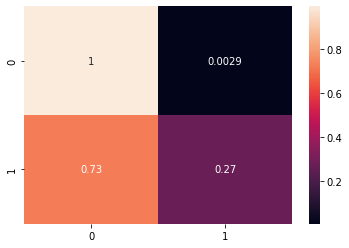

In [17]:
test_model(RC,X_test,y_test)

Widzymy że las losowy głównie stara się przewidzieć klasę która jest najbardziej reprezenowana

In [18]:

kernel_regularizer = regularizers.l2(1e-5)
bias_regularizer = regularizers.l2(1e-5)
model = tf.keras.Sequential()
tf.keras.layers.Input(19),
model.add(tf.keras.layers.Dense(256, activation = 'relu',
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer))
model.add(tf.keras.layers.Dense(256, activation = 'relu',
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer))
model.add(tf.keras.layers.Dense(64, activation = 'relu',
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer))

model.add(tf.keras.layers.Dense(2, activation = 'softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [19]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train)

In [20]:
h = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_val, y_val), 
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True,start_from_epoch=30)],verbose =1)

Epoch 1/150
3789/3789 [==============================] - 9s 2ms/step - loss: 334.6767 - accuracy: 0.6967 - val_loss: 1.0465 - val_accuracy: 0.6557
Epoch 2/150
3789/3789 [==============================] - 8s 2ms/step - loss: 0.6319 - accuracy: 0.7669 - val_loss: 0.4836 - val_accuracy: 0.7845
Epoch 3/150
3789/3789 [==============================] - 8s 2ms/step - loss: 5.2990 - accuracy: 0.7636 - val_loss: 0.5293 - val_accuracy: 0.7600
Epoch 4/150
3789/3789 [==============================] - 9s 2ms/step - loss: 0.5394 - accuracy: 0.7638 - val_loss: 0.5130 - val_accuracy: 0.7702
Epoch 5/150
3789/3789 [==============================] - 8s 2ms/step - loss: 0.7176 - accuracy: 0.7591 - val_loss: 0.7133 - val_accuracy: 0.7032
Epoch 6/150
3789/3789 [==============================] - 8s 2ms/step - loss: 0.5971 - accuracy: 0.7391 - val_loss: 0.6582 - val_accuracy: 0.6791
Epoch 7/150
3789/3789 [==============================] - 8s 2ms/step - loss: 0.5876 - accuracy: 0.7385 - val_loss: 0.5388 - val_

accuracy : 0.7639672585460623, ballanced accuracy: 0.7984762389986021,recal 0.833764553686934 


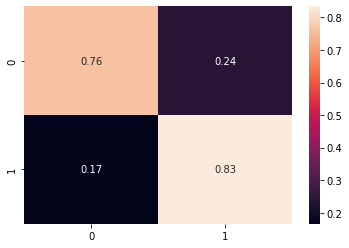

In [21]:
test_model(model,X_test,y_test,True)

Widzimy że model oparty na ssn działą o wiele lepiej, choć mamy mniejszą dokładność to recal jest zdecydowanie zadawalający.

Model z czasem może się dezaktualizować "na produkcji" ponieważ duża część zmiennych na podstawie których oceniamy jest podatna na wpływ czasu, niektóre domeny mogą się zieniać, jakieś państwo może wprowadzić jakąś ustawę związaną z łatwiejszym / trudniejszym hostingiem co może wpłynąć na wynik. Możemy również dostawać większą cześć stron hostowaną w innym kraju niż usa lub w innym alfabecie niż łacińskim. Takich elementów które mogą się zmienić jest bardzo dużo dlatego warto mieć jakiś system feedbacku jak model się sprawuje i go przetrenowywać raz na jakiś czas. 